In [51]:
import dask.array
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from os import path, listdir
from scipy.signal import savgol_filter

In [117]:
def find_peak(df : pd.DataFrame, channel="Cy3"):
    """Add a column that marks location of peak in the dataframe"""
    d = df[channel]

    df["peak"] = df[channel] > 0.5*(d.min() + d.max())
    return df


def get_edges(df : pd.DataFrame, channel="Cy3", w=0.8):
    df = find_peak(df, channel=channel)
    i = np.array(df[df.peak].index)

    # extract front edge
    a = i.min() - 2*w*i.ptp()
    b = i.min() + w*i.ptp()
    df["front"] = (df.index > a) & (df.index < b)

    # extract back edge
    a = i.max() - w*i.ptp()
    b = i.max() + 2*w*i.ptp()
    df["back"] = (df.index > a) & (df.index < b)
    return df


def where_eq(s, level, first=True):
    # find intersection points
    p = pd.Series(np.diff(np.sign(s - level)) != 0, index=s.index[:-1])
    if first:
        return p[p].index[0]
    else:
        return p[p].index[-1]


class Transition():
    def __init__(self, a, b):
        self.a, self.b = a, b
        self.tau = b - a


def analyze_transition(smooth_edge : pd.Series, margin=0.1):
    # Find midpoint
    x0 = where_eq(smooth_edge, 0.5*(smooth_edge.min()+smooth_edge.max()))

    # split into left and right
    left = smooth_edge.loc[:x0]
    right = smooth_edge.loc[x0:]

    up = left.median() < right.median()

    # steady state levels
    ls = left.median()  # np.quantile(left, 0.2 if up else 0.8)
    rs = right.median() # np.quantile(right, 0.8 if up else 0.2)

    m = margin*abs(ls - rs)

    #   front edge             back edge
    lt = ls + m if up else ls - m
    rt = rs - m if up else rs + m

    t = Transition(where_eq(left, lt, first=False), where_eq(right, rt, first=True))
    t.start = smooth_edge.index.min()
    t.end = smooth_edge.index.max()
    t.w = t.end - t.start
    t.low = min(ls, rs)
    t.high = max(ls, rs)
    t.ptp = t.high - t.low
    t.t_low = min(lt, rt)
    t.t_high = max(lt, rt)
    t.half = t.low + t.ptp/2
    t.t_diff = t.t_high - t.t_low
    return t


def show_dataset(df, front, back, ax):
    d = get_edges(df, "Cy3")
    ax.plot(d.Cy3, '.-', c='grey', alpha=0.2)
    ax.plot(d.Cy3s, 'k-', lw=0.5)

    def show_transition(t, c="gray", ha="left"):
        ax.add_patch(plt.Rectangle((t.start, t.low), t.w, t.ptp, lw=0.5, fc="none", ec=c, alpha=0.5))
        ax.add_patch(plt.Rectangle((t.a, t.t_low), t.tau, t.t_diff, lw=0.5, fc="none", ec="k"))
        ax.text(t.a if ha=="right" else t.b, t.half, f"  {t.tau:.0f} ms  ", ha=ha)

    show_transition(front, "darkgreen", ha="right")
    show_transition(back, "navy", ha="left")
    ax.set_xlabel("Time / ms")
    ax.set_ylabel("Photon count")


def analyze_csv(fn):
    df = pd.read_csv(fn, index_col='time')

    # convert s to ms
    df.index *= 1000

    # What channel contains the strongest signal?
    channel = df.drop(columns="frame").apply(np.ptp, axis=0).idxmax()

    # Smooth signal with savgol filter
    df[channel+"s"] = savgol_filter(df[channel], 61, 3)

    # Find front and back edges
    df = get_edges(df)

    front = analyze_transition(df.Cy3s[df.front])
    back = analyze_transition(df.Cy3s[df.back])
    return df, front, back

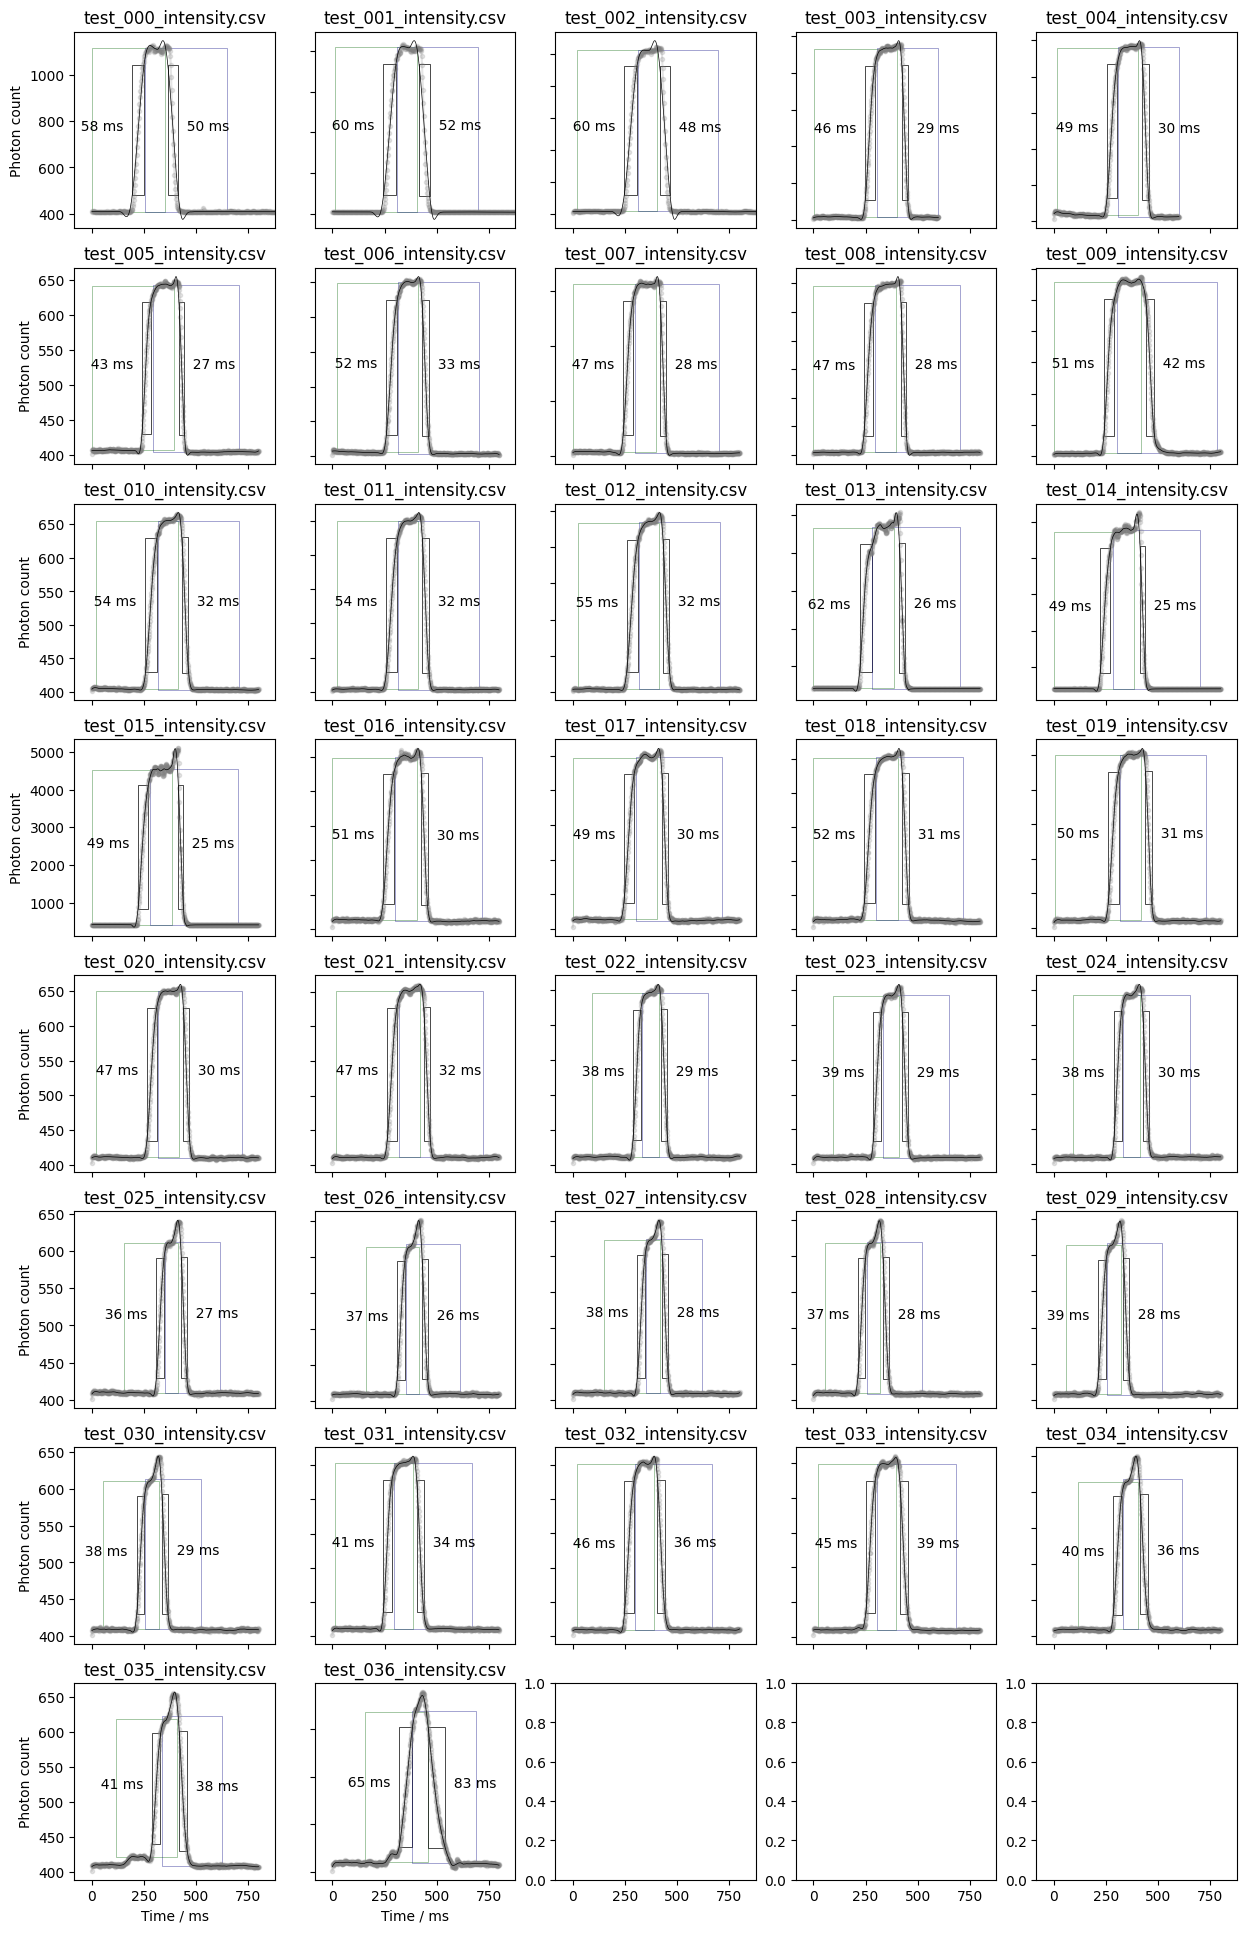

In [121]:
dir = r"sm_particle_counter/test/data/intensity"
lkw = dict(color="k", lw=0.1)
lkwr = dict(color="r", lw=0.2)


N = len(listdir(dir))
ncol = 5
nrow = (N-1) // ncol + 1
fig, axs = plt.subplots(nrow, ncol, figsize=(15,3*nrow), sharey=False, sharex=True)

xmin = 1e6
xmax = -1e6

timings = []
for i in range(N):
    col = i % ncol
    row = i // ncol
    fn = listdir(dir)[i]

    df, front, back = analyze_csv(path.join(dir, fn))
    timings.append(dict(fn=fn, front=front.tau, back=back.tau))

    ax = axs[row, col]

    xmin = min(front.start - 0.2*front.w, xmin)
    xmax = max(back.end + 0.2*back.w, xmax)

    show_dataset(df, front, back, ax)

    #ax.plot(df[channel], label=channel, color="lightblue")
    ax.set_title(fn)
    ax.label_outer()

ax.set_xlim(xmin, xmax);

plt.savefig("rise_time_analysis.pdf")

In [119]:
pd.DataFrame.from_dict(timings).to_csv("sm_particle_counter/test/data/timings.csv", sep="\t")

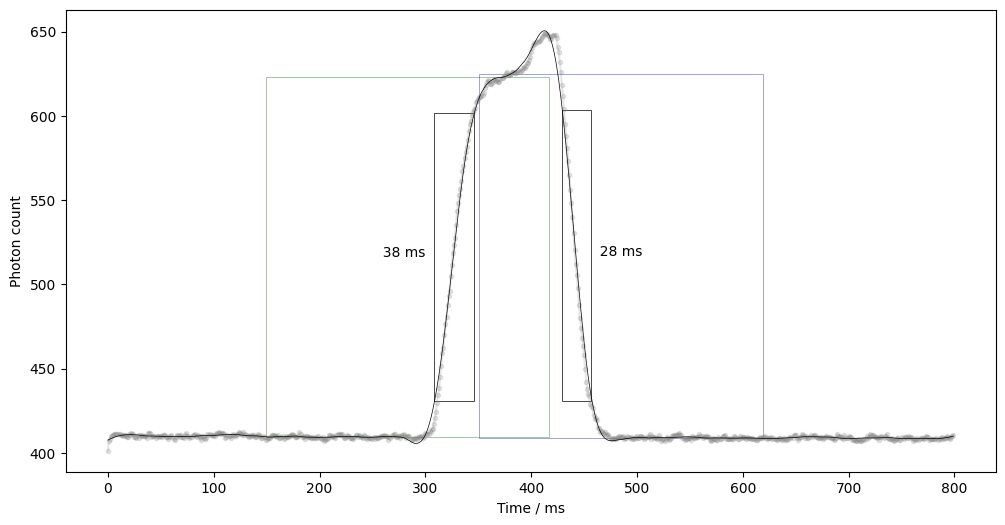

In [120]:
ax = plt.figure(figsize=(12,6)).gca()
df, front, back = analyze_csv(r"sm_particle_counter/test/data/intensity/test_027_intensity.csv")
show_dataset(df, front, back, ax)